In [1]:
#__Import libraries and script needed__
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Modules to analyse the Green's function kernel for real times with a frequency discretization in the complex plane
import DiscrError as de #module containing a class for the discretization error and various functions connected to it
import RtDlr as dlr #module containing the interpolative decomposition and various functions to make use of it (e.g. compute effective couplings,..)
from utils import common_funcs as cf #various functions needed to generate grids, compute spectral densities, etc..

In [2]:
#_____Set Parameters______

DEFAULT_PHI = np.pi / 4
params = {
    "m": None,  # to be updated for each computation
    "n": None,  # to be updated for each computation
    "N_max": None,  # not specified as we will directly pass the time grids "times"
    "delta_t": 0.1,  #this step that we will use below to set the time grids
    "beta": 20.0,  # inverse temperature
    "upper_cutoff": 600.,  # frequency cutoff for continous integrations
    "times": None,  # not specified as we will set it to different values below
    "h": None,  # to be updated for each computation
    "phi": DEFAULT_PHI,
}  # either "N_max" and "delta_t" OR "times" needs to be specified to define the time grid. If all is specified, the argument "times" is used as time grid


h_vals = np.log(
    np.arange(2, 1.0, -0.05)
)  # array with values of h which should be explored.
nbr_iterations = len(h_vals)

In [3]:
#_______Evaluate the error between the dicrete-frequency approximation and the continous-frequency integral_____
N_maxs = np.arange(50,60,20)

# create empty array in which to store DiscrError objects
discr_errors = np.empty(shape=(len(N_maxs),nbr_iterations), dtype=object)


for tau, N_max in enumerate(N_maxs):
    times = cf.set_time_grid(N_max = N_max, delta_t= params["delta_t"])
    cf.update_parameters(params, {"times": times})

    #_______Compute continuous integral results________
    cont_integral = np.array(
        [
            cf.cont_integral(t, params["beta"], params["upper_cutoff"])
            for t in params["times"]
        ]
    )  # array containing all values for the continuous integration result

    for i, h in enumerate(h_vals):
        cf.update_parameters(params, {"h": h})

        discr_error = de.DiscrError(
            **params
        )  # DiscrError object which holds the error w.r.t. to the continous results, and all associated parameters.

        discr_error.optimize(time_series_exact=cont_integral)  # optimize values for m and n

        #Exit the loop it error is below machine precision of if it does not keep shrinking with smaller h. Otherwise, append to array
      
        if cf.check_error_condition(
            eps_current=discr_error.eps,
            eps_previous=discr_errors[tau,i-1].eps if i > 1 else np.infty,
        ):
            break
        else:
            discr_errors[tau, i] = discr_error


Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 7.86164383673388e-17. Stopping the iteration.


In [13]:
#_____Evaluate the Real-time Kernel and its interpolative decomposition (ID)___
D = np.array([[dlr.RtDlr(discr_errors[tau,i]) for i in range (nbr_iterations)] for tau in range (len(N_maxs))]) # Use DiscrError object to initialize the kernel. This ensures that consistency of all parameters.

In [7]:
#_______Extract the data that we want to visualize below________
errors, m_vals, n_vals, h_vals, ID_ranks = cf.create_numpy_arrays(D)
nbr_modes_total = m_vals + n_vals

In [9]:
#_______Set global plot parameters____________
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})
cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.35, 0.9, len(N_maxs)))
colors_orange = cmaps[1](np.linspace(0.35, 0.9, len(N_maxs)))

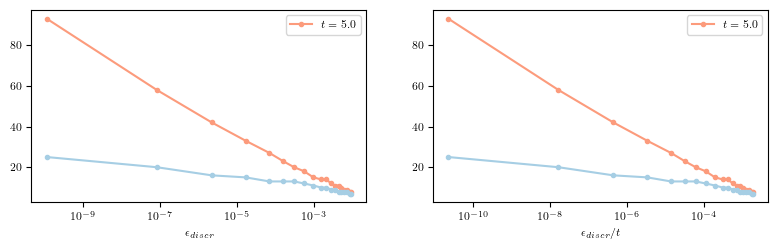

In [10]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(1, 2, figsize=(9.5, 2.5))
for tau in range (len(N_maxs)):
    axs[0].plot(errors[tau,:],nbr_modes_total[tau,:],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(N_maxs[tau] * params["delta_t"]))
    axs[0].plot(errors[tau,:], ID_ranks[tau,:], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)
    
axs[0].set_xlabel(r"$\epsilon_{discr}$")
#axs[0].text(1.e-8, 30, "Red: m+n,\n Blue: ID-rank")
axs[0].legend()
axs[0].set_xscale("log")

for tau in range (len(N_maxs)):
    axs[1].plot(errors[tau,:]/(N_maxs[tau] * params["delta_t"]),nbr_modes_total[tau,:],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(N_maxs[tau]* params["delta_t"]))
    axs[1].plot(errors[tau,:]/(N_maxs[tau] * params["delta_t"]), ID_ranks[tau,:], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)
    
axs[1].set_xlabel(r"$\epsilon_{discr} / t$")
#axs[1].text(1.e-8, 30, "Red: m+n,\n Blue: ID-rank")
axs[1].legend()
axs[1].set_xscale("log")

#plt.savefig("./plots/collapse.pdf", bbox_inches='tight')
